In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 사진 준비하기

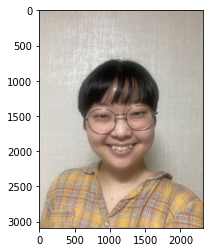

In [3]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png' #이미지 저장 경로
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy() # 출력용 이미지를 따로 복사하여 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # plt.imshow 이전에 RGB 이미지로 바꾸기
plt.imshow(img_rgb)
plt.show() # 사진 확인

# 얼굴 검출

In [4]:
# 얼굴 영역 찾기
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(723, 1256) (1682, 2215)]]


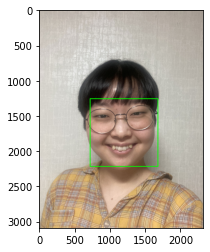

In [5]:
print(dlib_rects) # 찾은 얼굴영역의 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA) #선 굵기 10

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴 랜드마크

In [6]:
# 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
# 랜드마크 좌표 찾기
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


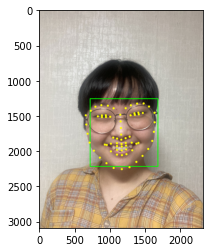

In [8]:
# 랜드마크 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 15, (0, 255, 255), -1) # point 크기 15

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 적용하기

In [9]:
# 스티커 이미지가 들어갈 좌표 & 크기 찾기
# 콧등 랜드마크, 스티커 이미지가 들어갈 위치 중앙점, 스티커 이미지의 너비&높이 총 3개의 좌표 값이 출력
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 30 = 콧등 랜드마크의 인덱스
    x = landmark[30][0] # 스티커 이미지의 중앙점 x좌표
    y = landmark[30][1] # 스티커 이미지의 중앙점 y좌표
    w = dlib_rect.width() # 스티커 이미지의 resize를 위한 박스 너비
    h = dlib_rect.height() # 스티커 이미지의 resizef를 위한 박스 높이
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(1162, 1765)
(x,y) : (1162,1765)
(w,h) : (960,960)


(960, 960, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

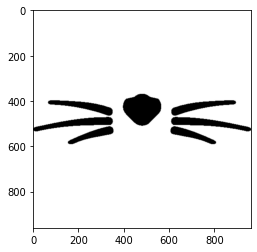

In [10]:
# 스티커 이미지 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png' #스티커 이미지 저장 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러오기
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

# 스티커 이미지 눈으로 확인
plt.imshow(img_sticker)
plt.show

In [11]:
# 스티커 이미지가 들어갈 좌표 다듬기
# 이미지 시작점은 top-left 좌표이기 때문
refined_x = x - w // 2
refined_y = y - h // 2

# refined_x나 refined_y가 음수로 출력될 경우 예외처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (682,1285)


In [12]:
# 스티커를 이미지에 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

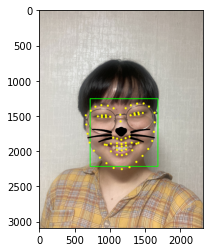

In [13]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

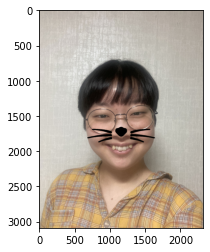

In [14]:
# bounding box와 landmark를 제거하고, 최종 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) #rgb로 전환
plt.show()

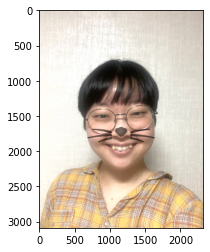

In [33]:
result = cv2.addWeighted(img_rgb, 0.5, cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB), 0.7, 0)
plt.imshow(result)

cv2.addWeighted(image1, a, image2, b, c, dst=None, dtype=None) 함수의 인자 설명
image1: 첫 번째 입력 이미지
a: 첫 번째 이미지의 가중치
image2: 두 번째 입력 이미지(image1과 같은 크기 & 타입)
b: 두 번째 이미지의 가중치
c: 결과 이미지에 추가적으로 더할 값
dst: 가중치 합 결과 이미지
dtype: 출력 이미지의 타입

정면 사진의 경우 이상 없이 결과가 출력된다. 그러나...

# 사진에서 피사체를 담은 각도가 기울어진 사진의 경우

# 사진 준비하기

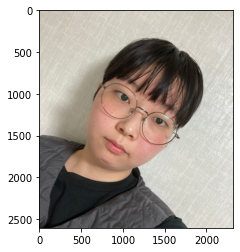

In [34]:
my_image_path_b = os.getenv('HOME')+'/aiffel/camera_sticker/images/image45.png'
img_bgr = cv2.imread(my_image_path_b)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출

In [35]:
# 얼굴 영역 찾기
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

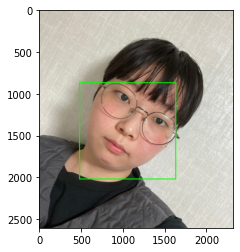

In [36]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA) #선 굵기 10

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 얼굴 랜드마크

In [37]:
# 랜드마크 좌표 찾기
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))


68


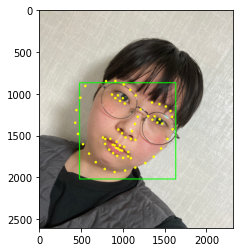

In [38]:
# 랜드마크 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 15, (0, 255, 255), -1) # point 크기 15

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용하기

(1111, 1448)


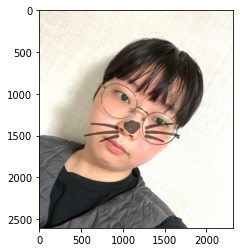

In [39]:
# 스티커 이미지가 들어갈 좌표 & 크기 찾기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    
# 스티커 이미지 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

# 스티커 이미지가 들어갈 좌표 다듬기
refined_x = x - w // 2
refined_y = y - h // 2

# refined_x나 refined_y가 음수로 출력될 경우 예외처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

# 스티커를 이미지에 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

# bounding box와 landmark를 제거하고, 최종 결과 이미지 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

#addWeighted함수로 스티커 이미지를 반투명하게 합성
result = cv2.addWeighted(img_rgb, 0.5, cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB), 0.7, 0)
plt.imshow(result)

피사체를 담은 각도가 기울어진 사진을 써도 얼굴 랜드마크는 이를 잡아내지만, 스티커는 그냥 정면으로 적용 되었다.
스티커를 위치시킬 좌표가 정면 사진일때와 동일하게 콧등 랜드마크의 인덱스를 기준으로 (기울어지지 않은)똑바른 직사각형으로 형성되었기 때문이다.
얼굴 랜드마크의 상대적인 위치 변화를 감지하여 구도가 기울어진 각도를 추정해내고, 스티커를 위치시킬 좌표를 그 각도에 맞춰 기울어지게 하면 얼굴 각도에 맞도록 스티커가 적용된 이미지를 결과로 볼 수 있을거라 생각한다.

더하여 개인적인 궁금증이 있는데, addWeighted함수를 사용하면 (스티커를 적용하지 않은)원본 이미지와 스티커가 적용된 결과 이미지를 덧셈연산하기 때문에 최종 결과 이미지에 약간의 명도 증가 효과가 강제적으로 들어가게 된다. 이런 현상 없이 어떻게 스티커만 자연스럽게 적용할 수 있을지 고민해봐야겠다.

# 회고

노드에 적힌 "스티커를 조금 더 자연스럽게 보이려면 어떻게 해야 할까요? opencv의 cv2.addWeighted()를 참고하세요."부분을 적용하기 위해 addWeighted 함수를 찾아보니, 합성하고자 하는 두 이미지의 크기와 타입이 같아야 한다고 해서 아주 당황했다. 대부분의 스티커 이미지는 필연적으로 전체 사진(얼굴 이미지)보다 작을거라고 생각했기 때문이다. 그래서 일단은 구현을 미루어두고 진행했는데 도중에 같은 조의 혜지님께서 "스티커를 적용하지 않은 원본 이미지와, 스티커를 적용한 이미지 두 개를 합치면 되지 않을까요?"라고 조언해주셔서 아르키메데스가 유레카를 외친 기분을 잠시 맛 보았다. 가위바위보 문제에서도, 이번 카메라 스티커 문제에서도 계시와 같은 말씀을 해주신 혜지님께 감사를 전한다.

지나간 두 개의 exploration은 사실 내가 뭘 어떻게 하고 있는건지 잘 와닿지 않았고, 결과값을 봐도 별 감흥이 없었다. 그런데 이번 것은 기본적으로 이미지를 다루다보니 시시각각 시각화된 결과가 눈으로 보이니 정말 재미있게 임했다. 다른 조원 분들은 인터넷에서 다운로드한 이미지를 많이 사용하시던데, 굳이 내 사진을 찍어 이용하는 것도 큰 즐거움이었다(스스로를 좋아하는 편!).